<a id="top"></a>
## Algorithme de Newmark - Bassins d'attraction - Oscillateur de Duffing

<div style="max-width:300px;float:left;margin-right:30px;">
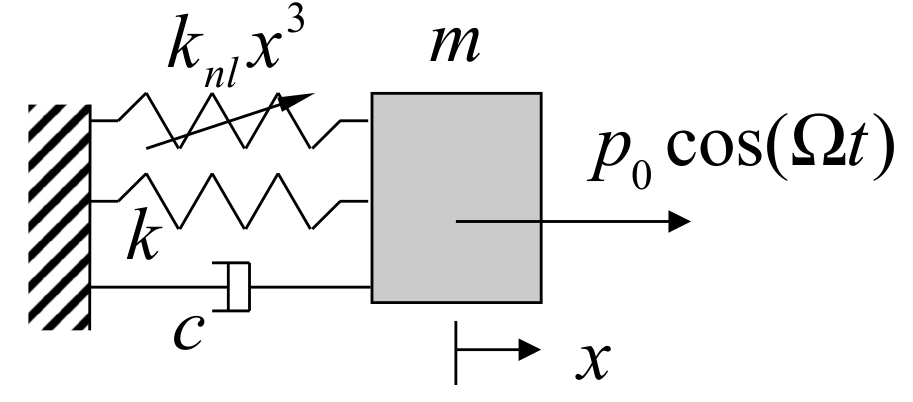
</div>
<div>
$x(t)$ : déplacement de la masse<br>
$m$ : masse<br>
$k$ : raideur<br>
$c$ : amortissement<br>
$k_{nl}$ : coefficient de la raideur non-linéaire<br>
$p_0$ : amplitude de l'excitation<br>
$\Omega$ : pulsation de l'excitation<br>
</div>


Equation du mouvement :
$\qquad m\ddot{x}(t)+ c\dot{x}(t) + kx(t) + k_{nl} x^3(t) = p_0 cos(\Omega t)$

[Algorithme de Newmark](#Algorithme-de-Newmark) |
[Validation avec solve_ivp de Scipy](#solve_ivp) |
[Sensibilité aux conditions initiales](#sensibilite_CI) |
[Courbe de réponse](#Courbe-de-réponse)  |
[Bassin d'attraction](#Bassin-d'attraction)<br>
---

In [20]:
# import des librairies additionnelles
import numpy as np
from numpy import zeros
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, odeint
import time
%matplotlib notebook

### Définition des fonctions

In [21]:
def calc_P(p0,OMEGA,t):
    P=p0*np.cos(OMEGA*t)
    return P

def calc_Fnl(knl,X,dX):
    Fnl=knl*X**3
    return Fnl

def calc_dFnl(knl,X,dX):
    dFX=3*knl*X**2
    dFdX=0
    return dFX,dFdX

---
### Algorithme de Newmark
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>

In [22]:
def Newmark(X0,dX0,t_init,dt,NT):
    precNR=1.e-9
    # C.I. déplacement et vitesse
    t=t_init
    X=X0;dX=dX0
    # initialisation des variables
    Fnl=0
    dFX=0
    dFdX=0
    P=0
    # tableaux de stockage des résultats à chaque pas de temps
    tt=zeros((NT,1))         # temps
    Xt=zeros((NT,1))      # déplacement
    dXt=zeros((NT,1))     # vitesse
    
    P=calc_P(p0,OMEGA,t)     # calcul de l'effort extérieur
    Fnl=calc_Fnl(knl,X,dX)   # calcul de l'effort non-linéaire
    ddX=(P-C*dX-K*X-Fnl)/M   # accélération initiale
    tt[0]=t
    Xt[0]=X
    dXt[0]=dX
    
    # Boucle sur les pas de temps
    for n in range(1,NT):
        t=t+dt;
        # prediction
        iter=0;
        X=X+dt*dX+(dt**2/2)*ddX
        dX=dX+dt*ddX
        ddX=ddX
        # Calcul du residu
        P=calc_P(p0,OMEGA,t)
        Fnl=calc_Fnl(knl,X,dX)
        res=P-M*ddX-C*dX-K*X-Fnl
        normres=abs(res/P)
        # Iterations de Newton Raphson
        while (normres>precNR):
            iter=iter+1
            # Calcul de la Jacobienne
            dFX,dFdX=calc_dFnl(knl,X,dX)
            J=(4/dt**2)*M+(2/dt)*(C+dFdX)+K+dFX
            # Calcul de la correction
            deltaX=res/J
            X=X+deltaX
            # mise à jour vitesse et accélération
            dX=dX+(2/dt)*deltaX
            ddX=ddX+(4/dt**2)*deltaX
            # Calcul du residu
            Fnl=calc_Fnl(knl,X,dX)
            res=P-M*ddX-C*dX-K*X-Fnl
            #normres=abs(res/P)
            normres=abs(deltaX/X)
        tt[n]=t     # stockage t(n)
        Xt[n]=X     # stockage X(n)
        dXt[n]=dX   # stockage dX(n)
    return tt,Xt,dXt

### Paramètres du système

In [23]:
M=1
C=0.1
K=1
knl=0.25
p0=.5
OMEGA=1.

periode=2*np.pi/OMEGA  # periode de l'excitation et de la reponse
nb_pts_per=30          # nb de points par periode pour l integration temporelle
dt=periode/nb_pts_per  # taille du pas de temps
nb_per=30              # nb de periodes pour le calcul temporel
t_tot=nb_per*periode   # temps final
t_init=0               # temps initial
NT=nb_per*nb_pts_per+1 # Nb total de pas de temps

### Résolution des équations du mouvement par Newmark et tracé de la réponse temporelle $x(t)$
Excitation $\Omega=1$<br>
C.I. $x(0)=0$, $\dot{x}(0)=0$

ellapsed time:  0.01637599999997974


<IPython.core.display.Javascript object>


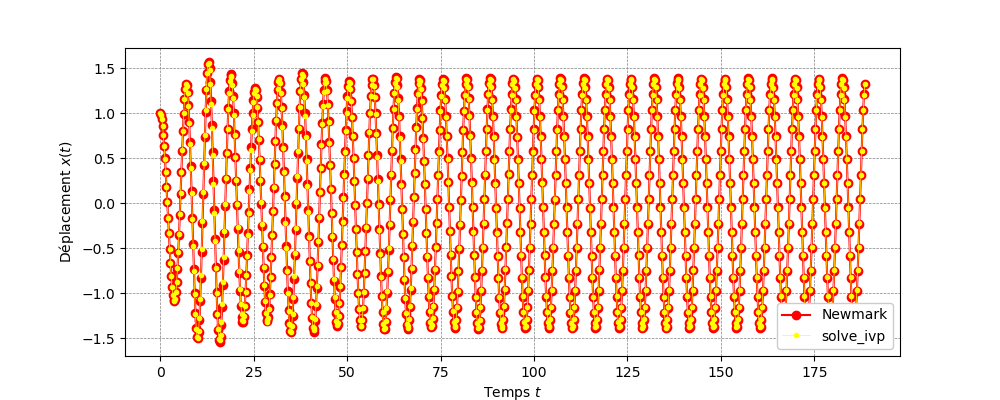

In [24]:
OMEGA=1.
X0=1;dX0=0             # conditions initiales
start = time.process_time()
tt,Xt,dXt=Newmark(X0,dX0,t_init,dt,NT)   # Integration par Newmark
print('ellapsed time: ',time.process_time() - start)

fig = plt.figure(figsize=(10, 4))  # Crée une figure de dimensions données.
ax = plt.gca()  # Récupération des axes.
ax.plot(tt, Xt, color='red',marker = 'o', label='Newmark')  # Trace le deplacement en fonction du temps.
plt.xlabel("Temps $t$")        # titre axe horizontal
plt.ylabel("Déplacement $x(t)$")  # titre axe vertical
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()

---
<a id="solve_ivp"></a>
### Validation par comparaison avec solve_ivp (schéma RK45) de Scipy
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>
Superposition des résultats sur la courbe précédente

In [25]:
# Equation différentielle du mouvement sous forme d'état
def duffing(t, z):
    x,y =z
    dxdt=y
    dydt=-C*y-K*x-knl*x**3+p0*np.cos(OMEGA*t)
    return [dxdt, dydt]

In [26]:
# Resolution par solve_ivp
solinit = [X0, dX0]
tt = np.linspace(t_init, t_tot, NT)
start = time.process_time()
sol = solve_ivp(duffing, (t_init, t_tot), solinit, method="RK45", t_eval=tt, rtol=1e-9, atol=1e-9)
print('ellapsed time: ',time.process_time() - start)
plt.sca(ax)  # reactive la figure précédente
ax.plot(sol.t, sol.y[0], color='yellow', linewidth = 0.5, marker = '.', label='solve_ivp')
plt.legend(loc='lower right',framealpha=1)
plt.show()
print('\n** Figure précédente mise à jour ! **\n')

ellapsed time:  0.3918079999999975

** Figure précédente mise à jour ! **



<div class="alert alert-block alert-info">
<b>Rem :</b> Attention à demander une précision suffisante !<br>
Le solveur solve_ivp assure une erreur locale inférieure à <code>atol+rtol*abs(x)</code>.
Valeurs par défaut : 1e-3 pour rtol et 1e-6 pour atol.<br>
Plus d'infos ici : <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html">Doc de référence Scipy - solve_ivp</a>
</div>

---
### Courbe de réponse
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>

In [27]:
OMEGA_debut=.5;OMEGA_fin=2.5;dOMEGA=0.05
nb_pts_per=50          # nb de points par periode pour l integration temporelle
nb_per=50              # nb de periodes pour le calcul temporel
t_init=0               # temps initial
NT=nb_per*nb_pts_per   # Nb total de pas de temps
npas=int((OMEGA_fin-OMEGA_debut)/dOMEGA+1)
# conditions initiales
X0=0.5;dX0=0
k=0; OMEGA=OMEGA_debut

OME=zeros((npas,1))
AMPL=zeros((npas,1))
# boucle sur Omega 
while (OMEGA<OMEGA_fin):
    OME[k]=OMEGA
    periode=2*np.pi/OMEGA   # periode de l'excitation et de la reponse
    dt=periode/nb_pts_per   # mise a jour du pas de temps
    t_tot=nb_per*periode    # mise a jour du temps final
    tt,Xt,dXt=Newmark(X0,dX0,t_init,dt,NT)   # Integration par Newmark
    AMPL[k]=max(Xt[-3*nb_pts_per:])   # recherche de l’amplitude max
    print(f'ome= {OME[k,0]:0.5f}  x= {AMPL[k,0]:0.5g}', end="\r", flush=True)   # affichage resultat
    X0=Xt[-1,0];dX0=dXt[-1,0]   # nouvelles CI
    OMEGA=OMEGA+dOMEGA
    k=k+1


<IPython.core.display.Javascript object>


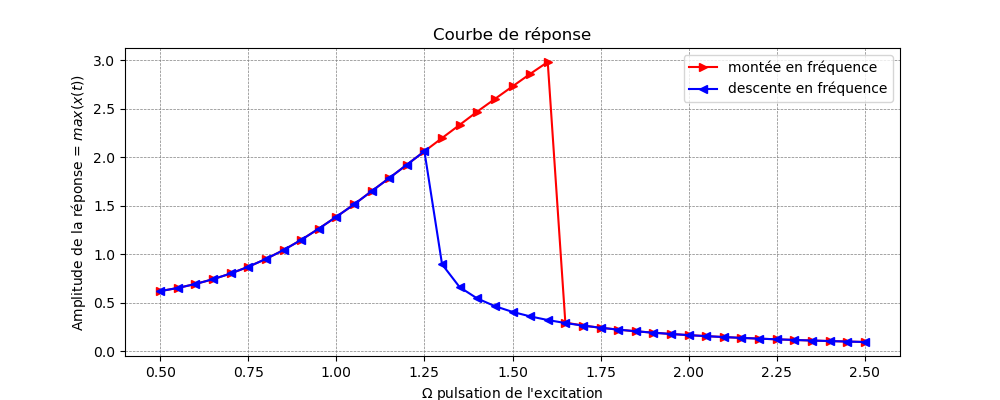

In [28]:
fig = plt.figure(figsize=(10, 4))  # Crée une figure de dimensions données.
ax = plt.gca()  # Récupération des axes.
ax.plot(OME, AMPL, color='red',marker = '>', label='montée en fréquence')  # Trace la courbe de réponse.
plt.xlabel("$\Omega$ pulsation de l'excitation")
plt.ylabel("Amplitude de la réponse = $max(x(t))$")
plt.title("Courbe de réponse")
plt.legend()
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()


In [29]:
k=0; OMEGA=OMEGA_fin

npas=int((OMEGA_fin-OMEGA_debut)/dOMEGA+1)
#OMEGA=np.linspace(OMEGA_debut, OMEGA_fin, num=npas)
OME2=zeros((npas,1))
AMPL2=zeros((npas,1))
# boucle sur Omega 
start = time.process_time()
while (OMEGA>OMEGA_debut):
    OME2[k]=OMEGA
    periode=2*np.pi/OMEGA      # periode de l'excitation et de la reponse
    dt=periode/nb_pts_per  # taille du pas de temps
    t_tot=nb_per*periode   # temps final
    tt,Xt,dXt=Newmark(X0,dX0,t_init,dt,NT)   # Integration par Newmark
    AMPL2[k]=max(Xt[-3*nb_pts_per:])  # recherche de l’amplitude max
    print(f'ome= {OME2[k,0]:0.5f}  x= {AMPL2[k,0]:0.5g}', end="\r", flush=True)   # affichage resultat
    X0=Xt[-1,0];dX0=dXt[-1,0]   # nouvelles CI
    OMEGA=OMEGA-dOMEGA
    k=k+1
print('ellapsed time: ',time.process_time() - start)

ellapsed time:  1.0204510000000084


In [30]:
plt.sca(ax)  # reactive la figure précédente
ax.plot(OME2, AMPL2, color='blue',marker = '<', label='descente en fréquence')  # Trace la courbe de réponse.
plt.legend()
plt.show()
print('\n** Figure précédente mise à jour ! **\n')


** Figure précédente mise à jour ! **



---
<a id="sensibilite_CI"></a>
### Sensibilité aux conditions initiales (C.I.)
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>
Excitation $\Omega=1$<br>
Plusieurs C.I. différentes : $x(0)=0$, $\dot{x}(0)=0$  $\qquad$ $x(0)=2$, $\dot{x}(0)=0$  $\qquad$ $x(0)=2.5$, $\dot{x}(0)=0$

<IPython.core.display.Javascript object>


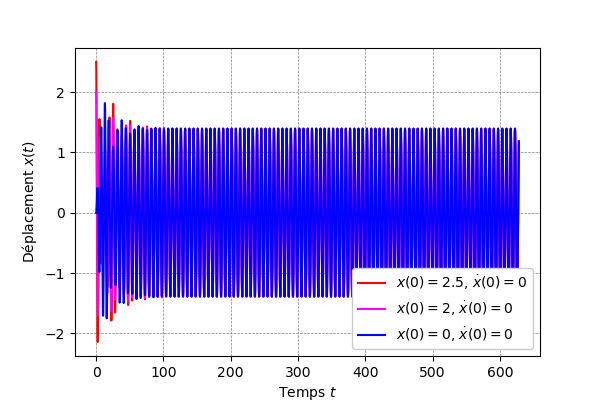

In [31]:
OMEGA=1.
X0=0;dX0=0             # encore d'autres conditions initiales
tt1,Xt1,dXt1=Newmark(X0,dX0,t_init,dt,NT)
X0=2;dX0=0             # encore d'autres conditions initiales
tt2,Xt2,dXt2=Newmark(X0,dX0,t_init,dt,NT)
X0=2.5;dX0=0            # encore d'autres conditions initiales
tt3,Xt3,dXt3=Newmark(X0,dX0,t_init,dt,NT)

fig = plt.figure(figsize=(6, 4))  # Crée une figure de dimensions données.
ax = fig.add_subplot()
ax.plot(tt3, Xt3, color='red', label='$x(0)=2.5$, $\dot{x}(0)=0$') 
ax.plot(tt2, Xt2, color='magenta', label='$x(0)=2$, $\dot{x}(0)=0$')
ax.plot(tt1, Xt1, color='blue', label='$x(0)=0$, $\dot{x}(0)=0$')
plt.xlabel("Temps $t$")
plt.ylabel("Déplacement $x(t)$")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend(loc='lower right',framealpha=1)
plt.show()

<div class="alert alert-block alert-info">
<b>Rem :</b> Pour $\Omega=1$ on obtient <strong>toujours la même solution</strong> en régime permanent quelles que soient les C.I.<br>
    Le régime transitoire diffère en fonction des C.I.
</div>

Excitation $\Omega=1.5$<br>
Plusieurs C.I. différentes : $x(0)=0$, $\dot{x}(0)=0$  $\qquad$ $x(0)=2$, $\dot{x}(0)=0$  $\qquad$ $x(0)=2.5$, $\dot{x}(0)=0$

<IPython.core.display.Javascript object>


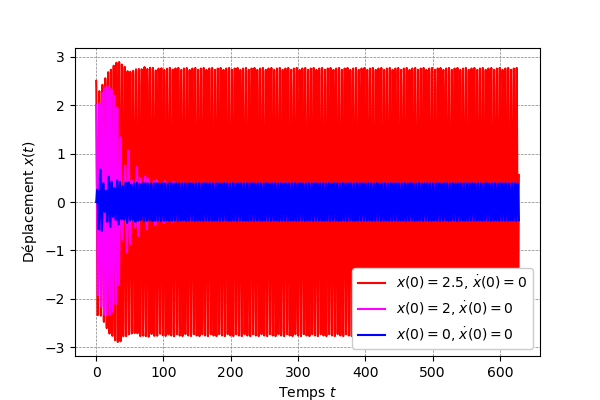

In [32]:
OMEGA=1.5
X0=0;dX0=0             # encore d'autres conditions initiales
tt1,Xt1,dXt1=Newmark(X0,dX0,t_init,dt,NT)
X0=2;dX0=0             # encore d'autres conditions initiales
tt2,Xt2,dXt2=Newmark(X0,dX0,t_init,dt,NT)
X0=2.5;dX0=0            # encore d'autres conditions initiales
tt3,Xt3,dXt3=Newmark(X0,dX0,t_init,dt,NT)

fig = plt.figure(figsize=(6, 4))  # Crée une figure de dimensions données.
ax = fig.add_subplot()
ax.plot(tt3, Xt3, color='red', label='$x(0)=2.5$, $\dot{x}(0)=0$') 
ax.plot(tt2, Xt2, color='magenta', label='$x(0)=2$, $\dot{x}(0)=0$')
ax.plot(tt1, Xt1, color='blue', label='$x(0)=0$, $\dot{x}(0)=0$')
plt.xlabel("Temps $t$")
plt.ylabel("Déplacement $x(t)$")
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.legend(loc='lower right',framealpha=1)
plt.show()

<div class="alert alert-block alert-info">
<b>Rem :</b> Pour $\Omega=1.5$ on obtient des <strong>solutions différentes</strong> en régime permanent selon les C.I. choisies !!!<br>
</div>

---
### Bassin d'attraction
<div style="text-align: right">
<a href="#top">[Back to top]</a>
</div>

<IPython.core.display.Javascript object>


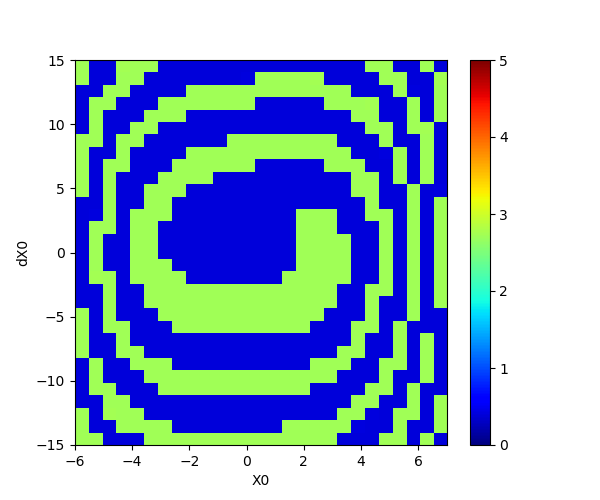

In [33]:
#OMEGA=1.35
OMEGA=1.5
#OMEGA=1.62
periode=2*np.pi/OMEGA  # periode de l'excitation et de la reponse
nb_pts_per=31          # nb de points par periode pour l integration temporelle
dt=periode/nb_pts_per  # taille du pas de temps
nb_per=40              # nb de periodes pour le calcul temporel
t_tot=nb_per*periode   # temps final
t_init=0               # temps initial
NT=nb_per*nb_pts_per

# Conditions initiales
# pas de la grille
pasX=0.5; pasdX=1     # grille grossiere
#pasX=0.2; pasdX=.4    # grille moyenne
#pasX=0.1; pasdX=.2   # grille fine
# bornes de la grille
X0=np.arange(-6, 7+pasX, pasX)     
dX0=np.arange(-15, 15+pasdX, pasdX)

AMPL=zeros((len(dX0),len(X0)))

fig1 = plt.figure(figsize=(6, 5))  # Crée une figure de dimensions données.
ax1 = fig1.add_subplot()
ax1.set_xlabel('X0')
ax1.set_ylabel('dX0')
im = ax1.imshow(AMPL, interpolation='none', aspect='auto',extent=[-6,7,-15,15],vmin=0,vmax=5, cmap='jet')
fig1.colorbar(im, ax=ax1)
fig1.canvas.draw()

# start = time.process_time()
for i in range(0,len(X0)):   # boucle sur les CI
    for j in range(0,len(dX0)):
        tt,Xt,dXt=Newmark(X0[i],dX0[j],t_init,dt,NT)
        AMPL[j,i]=max(Xt[-2*nb_pts_per:])
    im.set_data(AMPL)
    fig1.canvas.draw()
# print('ellapsed time: ',time.process_time() - start)
